# Playing around fashionMNSIT

In [1]:
from IPython.display import Markdown
import datetime

now = datetime.datetime.now()
markdown_str = f"Last update: {now} "

display(Markdown(markdown_str))

Last update: 2023-05-04 17:31:17.470421 

The following running is done on a test set of $1000$ data.

In [2]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

## Loading the data using torchvision

In [3]:
# Defining transforms 
to_tensor = transforms.ToTensor()
normalization = transforms.Normalize(mean=0.286, std=0.353)

data_transforms = transforms.Compose([to_tensor, normalization])

# load the data
train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=data_transforms, download=True, 
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=data_transforms, download=True
)


# sample from train_dataset 1000 images from training and 333 for test
SAMPLE_SIZE = 1000  # for training
TEST_SAMPLE_SIZE = int(0.3*SAMPLE_SIZE)


np.random.seed(0)
train_idxs = np.random.choice(train_dataset.data.shape[0], size=SAMPLE_SIZE, replace=False)
test_idxs =  np.random.choice(test_dataset.data.shape[0], size=TEST_SAMPLE_SIZE, replace=False)

# Split the data into X_train, y_train, X_test and y_test TENSORS
X_train = train_dataset.data[train_idxs].view(SAMPLE_SIZE, 1, 28, 28)
y_train = train_dataset.targets[train_idxs]
X_test = test_dataset.data[test_idxs].view(TEST_SAMPLE_SIZE, 1, 28, 28)
y_test = test_dataset.targets[test_idxs]

X_train = X_train.to(dtype=th.float) # casting X_train to a floating point data type
X_train = (X_train - X_train.mean()) / X_train.std() # normalize
X_test = X_test.to(dtype=th.float) # casting X_test to a floating point data type
X_test = (X_test - X_test.mean()) / X_test.std() # normalize


# Define the DataLoader to be used during Neural Network training

# Define the batch_size to perform stochastic gradient descent
BATCH_SIZE = 10
train_loader = DataLoader(dataset=list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True)

# Define training and test set to be used with numpy

# Reshape and normalize training set to numpy
X_train_p = X_train.reshape(SAMPLE_SIZE, 28, 28)
X_train_np = th.Tensor.numpy(X_train_p).reshape(SAMPLE_SIZE, 28*28) # X_train_np is the training set "translated" in numpy
X_train_np = (X_train_np - X_train_np.mean())/X_train_np.std()
y_train_np = th.Tensor.numpy(y_train).reshape(SAMPLE_SIZE)

# Reshape and normalize test set to numpy
X_test_p = X_test.reshape(TEST_SAMPLE_SIZE, 28, 28)
X_test_np = th.Tensor.numpy(X_test_p).reshape(TEST_SAMPLE_SIZE, 28*28) # X_train_np is the training set "translated" in numpy
X_test_np = (X_test_np - X_test_np.mean())/X_test_np.std()
y_test_np = th.Tensor.numpy(y_test).reshape(TEST_SAMPLE_SIZE)


**Remark:** \
To remove the channel size, which we don't care outside neural network training, reshape `X_train` tensor (1000x1x28x28) to `X_train_p` tensor (1000x28x28); then we export `X_train_p` (1000x28x28) and `y_train` (1000) tensors into `X_train_np` (1000x28x28) and `y_train_np` (1000) numpy array, to use them with `sklearn`. \
Finally we reshape `X_train_np` to size (1000x784) to work with `sklearn`. 

Summarizing:
 - `X_train`, `y_train` are `tensor` objects and used in NN training 
 - `X_train_np`, `y_train_np` are `numpy.arrays` and used in `sklearn` modules.

**Remark:** 
- every time i call `train_loader`, a batch of `BATCH_SIZE = 10` images with their labels is extracted form the `SAMPLE_SIZE` examples belonging to the *mini-training dataset* `X_train, y_train`.
- every time i call `test_loader`, a batch of `BATCH_SIZE = 10` images with their labels is extracted form the `TEST_SAMPLE_SIZE` examples belonging to the *mini-test dataset* `X_test, y_test`.

The following code is to compute the mean and the standard deviation of the dataset, to be used inside `transfroms.Normalization` function. \
We get the following value:
 - mean = 0.286
 - sd = 0.353

In [4]:
"""
to_tensor = transforms.ToTensor()
data_transforms = transforms.Compose([to_tensor])

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, transform=data_transforms, download=True
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, transform=data_transforms, download=True
)

X_train = th.Tensor.numpy(train_dataset.data)
y_train = th.Tensor.numpy(train_dataset.targets.data)

print(X_train.mean()/X_train.max())
print(X_train.std()/X_train.max())
mean = X_train.sum()/X_train.max()
sd = X_train.std()/X_train.max()
"""

'\nto_tensor = transforms.ToTensor()\ndata_transforms = transforms.Compose([to_tensor])\n\ntrain_dataset = datasets.FashionMNIST(\n    root="./data", train=True, transform=data_transforms, download=True\n)\ntest_dataset = datasets.FashionMNIST(\n    root="./data", train=False, transform=data_transforms, download=True\n)\n\nX_train = th.Tensor.numpy(train_dataset.data)\ny_train = th.Tensor.numpy(train_dataset.targets.data)\n\nprint(X_train.mean()/X_train.max())\nprint(X_train.std()/X_train.max())\nmean = X_train.sum()/X_train.max()\nsd = X_train.std()/X_train.max()\n'

In [5]:
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Plot some images from the dataset.

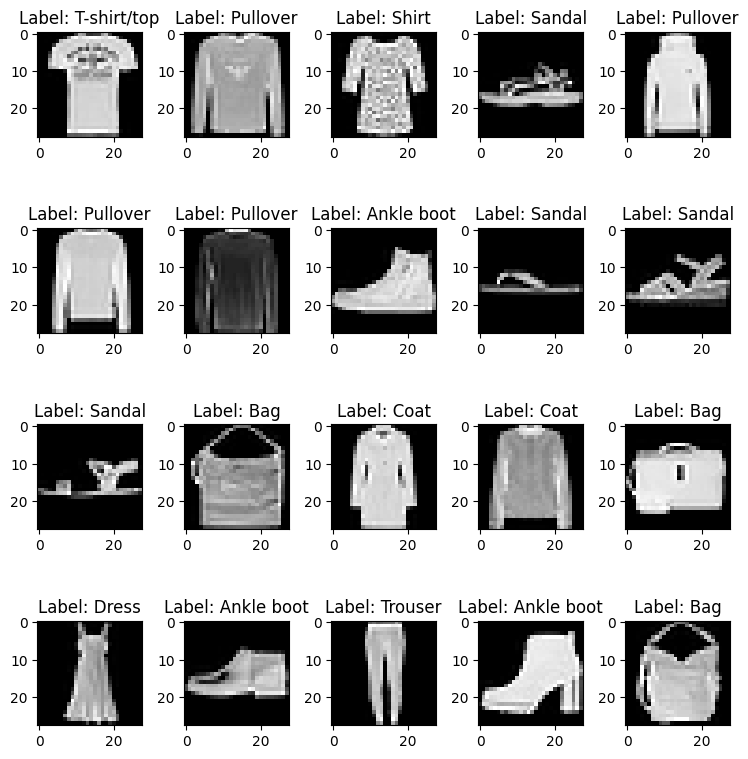

In [6]:
# plot using X_train_p (cause i want shape 28x28, NOT 784)
n_row = 4
n_col = 5

n=n_row * n_col
images=X_train_p[:n]
labels=y_train_np[:n]

fig, axes=plt.subplots(n_row, n_col, figsize=(1.5*n_col, 2*n_row))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

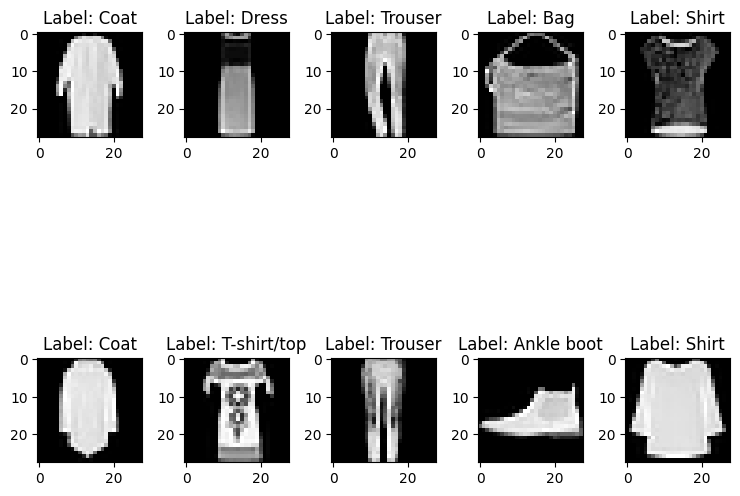

In [7]:
# plot using training_loader (meaning that each run, I'll view differetn images)
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

fig, axes=plt.subplots(2, 5, figsize=(1.5*n_col, 2*n_row))
for i in range(BATCH_SIZE):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i].view(28,28), cmap='gray')
    ax.set_title(f"Label: {classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


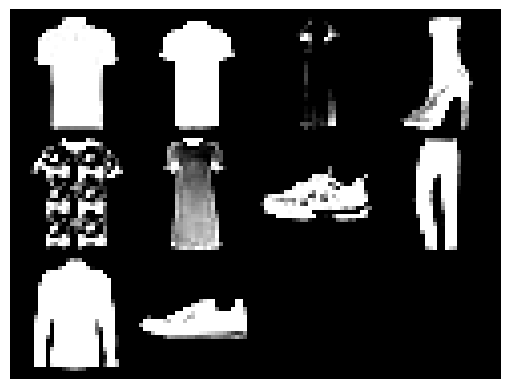

In [8]:
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(torchvision.utils.make_grid(images, nrow=4))

Feature batch shape: torch.Size([1000, 1, 28, 28])
Labels batch shape: torch.Size([1000])


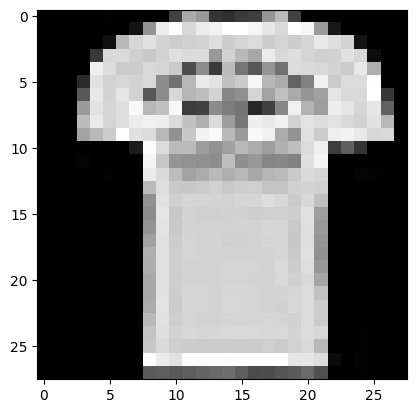

Label: T-shirt/top


In [9]:
print(f"Feature batch shape: {X_train.size()}")
print(f"Labels batch shape: {y_train.size()}")
img = X_train[0].squeeze()
label = y_train[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {classes_names[label]}")

In [10]:
# just check that data now are normalized
print(np.mean(X_train_np), np.std(X_train_np))
print(y_train.shape)
print(y_train[:10])


2.9116261e-08 0.9999999
torch.Size([1000])
tensor([0, 2, 6, 5, 2, 2, 2, 9, 5, 5])


## 1 - Understanding data geometry

### Linear PCA

Linear PCA on 2 and 3 principal components

In [11]:
from sklearn.decomposition import PCA
# perform PCA with 2 components
pca = PCA()
X_new = pca.fit_transform(X_train_np)
print(X_new.shape)

(1000, 784)


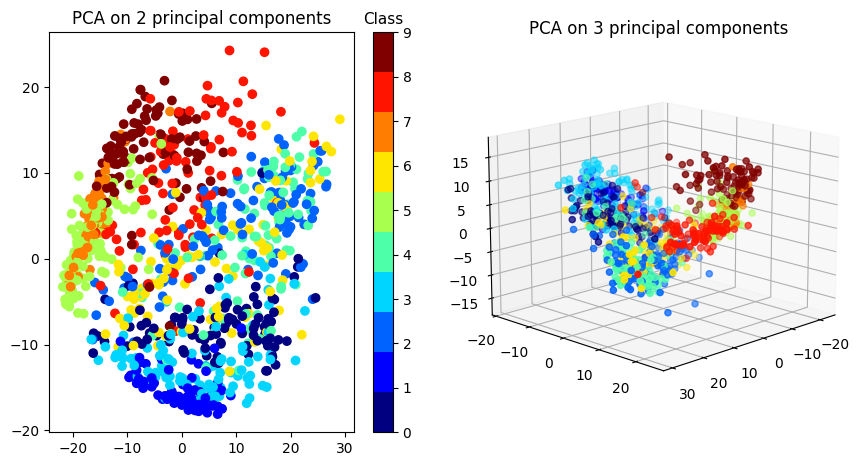

In [12]:
import matplotlib.pyplot as plt

# Create the first subplot (2D plot)
fig = plt.figure(figsize=(10,5))
cmap = plt.get_cmap('jet', 10) #
ax1 = fig.add_subplot(121)
p=ax1.scatter(X_new[:,0], X_new[:,1], c=y_train_np, cmap=cmap)
ax1.set_title('PCA on 2 principal components')

# Create the second subplot (3D plot)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(X_new[:,0], X_new[:,1], X_new[:,2], c=y_train_np, cmap=cmap)
ax2.view_init(15, 45)
ax2.set_title('PCA on 3 principal components')

# Adjust the layout and padding of the subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1)

# Show the plots
cb = plt.colorbar(p) #
cb.ax.set_title('Class', fontsize=11) #
plt.show()


How images "appears" after PCA

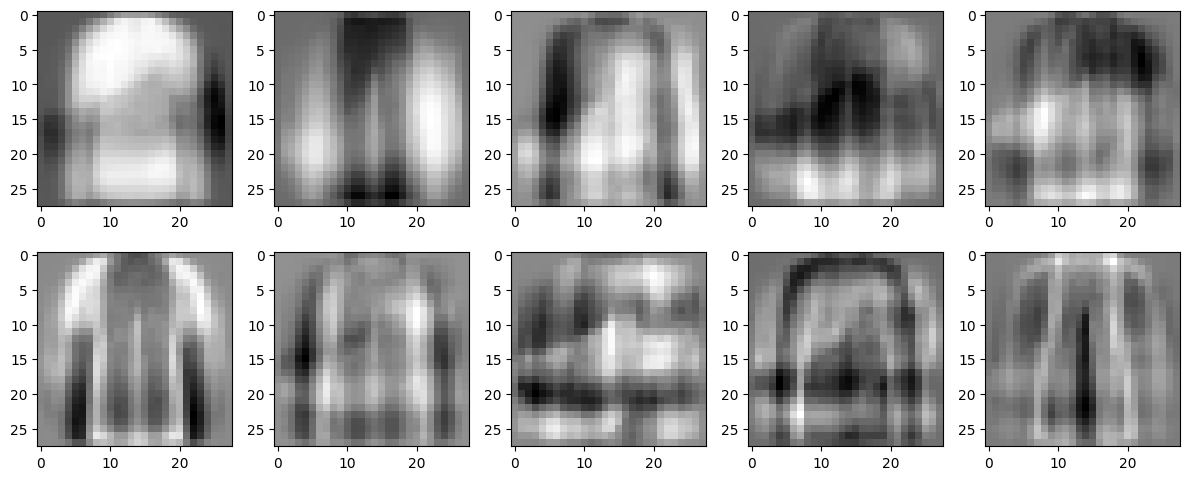

In [13]:
pc_10 = [pca.components_[i].reshape(28,28) for i in range(0,10)]
fig, axes=plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(pc_10[i], cmap='gray')
plt.tight_layout()
plt.show()

### Kernel Gaussian PCA

Gaussian kernel PCA on 2 and 3 components with default `gamma = 1/n_features`

In [14]:
from sklearn.decomposition import KernelPCA

kernel_pca = KernelPCA(n_components = 3, kernel = 'rbf')
X_new = kernel_pca.fit_transform(X_train_np)
print(X_new.shape)


(1000, 3)


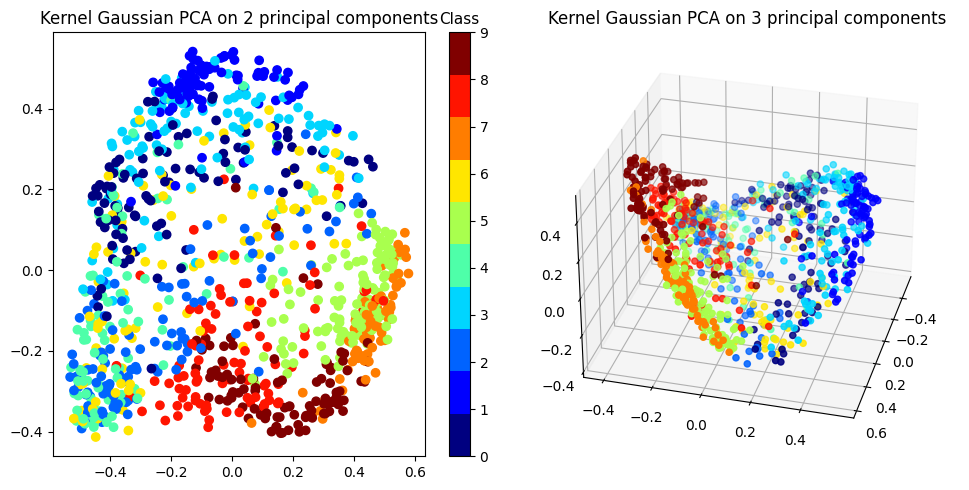

In [15]:
import matplotlib.pyplot as plt

# Create the first subplot (2D plot)
fig = plt.figure(figsize=(10,5))
camp = plt.get_cmap('jet', 10) #
ax1 = fig.add_subplot(121)
p=ax1.scatter(X_new[:,0], X_new[:,1], c=y_train_np, cmap=cmap)
ax1.set_title('Kernel Gaussian PCA on 2 principal components')

# Create the second subplot (3D plot)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(X_new[:,0], X_new[:,1], X_new[:,2], c=y_train_np, cmap=cmap)
ax2.view_init(30,15)
ax2.set_title('Kernel Gaussian PCA on 3 principal components')

# Adjust the layout and padding of the subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1)

# Show the plots
cb = plt.colorbar(p) #
cb.ax.set_title('Class', fontsize=11) #

plt.tight_layout()
plt.show()


Tune the dispersion parameter gamma:
- plot the 3-dim projection of the data using `gamma` from `param_grid`
- choose the `gamma` fo
r which the projection is best explainaied geometrically

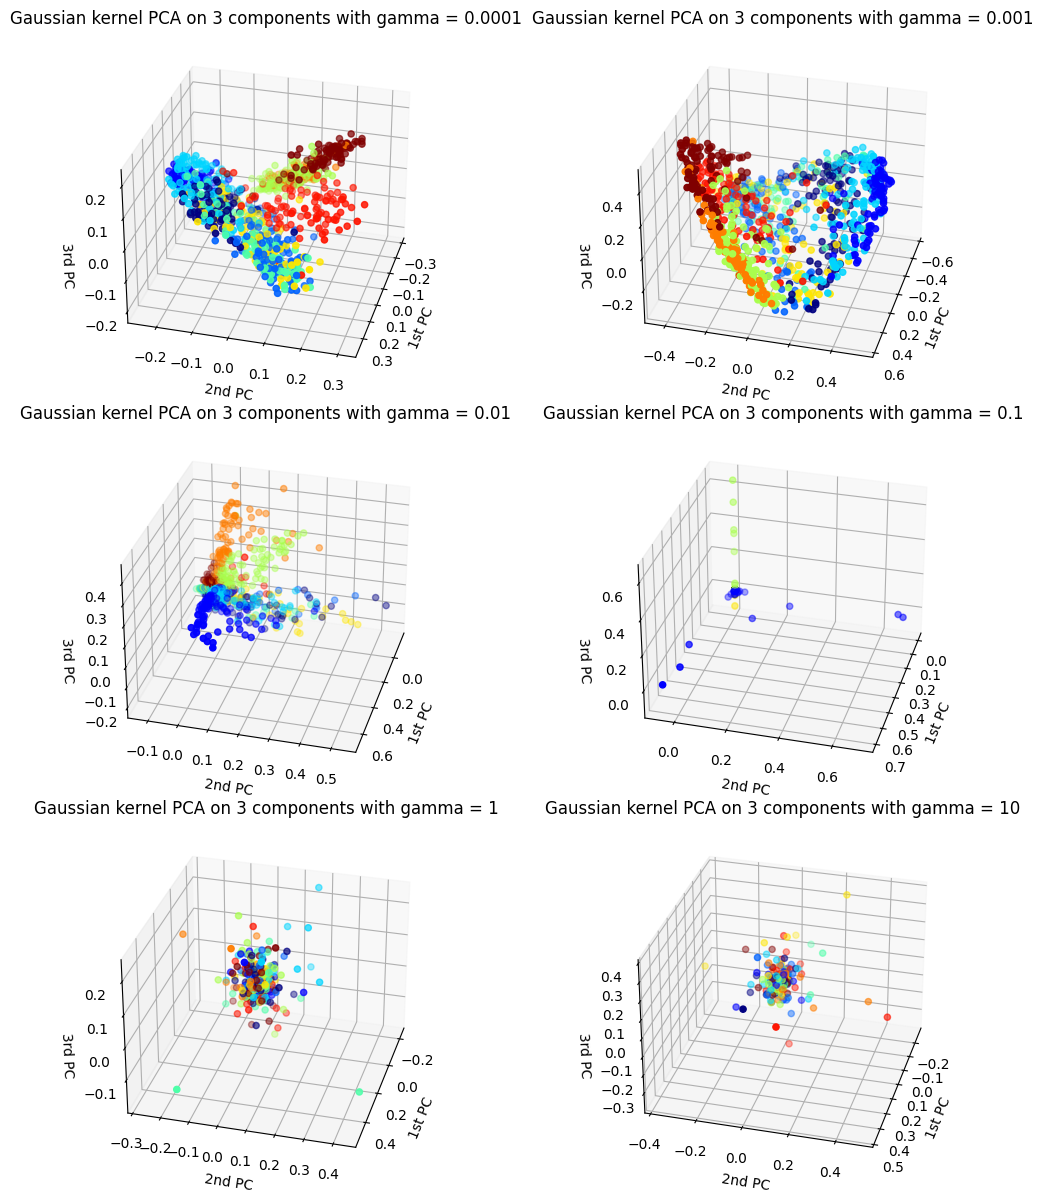

In [16]:
param_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), subplot_kw={'projection': '3d'})
camp = plt.get_cmap('jet', 10) #
axes = axes.flatten()

for i in range(len(param_grid)):
    kernel_pca = KernelPCA(n_components=3, kernel='rbf', gamma=param_grid[i])
    X_new = kernel_pca.fit_transform(X_train_np)

    ax = axes[i]
    ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2], c=y_train_np, cmap = cmap)
    ax.view_init(30, 15)
    ax.set_title(f'Gaussian kernel PCA on 3 components with gamma = {param_grid[i]}')
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    ax.set_zlabel('3rd PC')

fig.tight_layout()
plt.show()


Clearly, with `gamma` greater than $0.1$, the projection is not so good. Conversly, with `gamma` close to $0$ the projection allows to understand pretty well the underlying geometry of the data: we can clearly see a separation between "brighter" and "darker" labels.

### Kernel Polynomial PCA

Perform polynomial kernel PCA on 3 principal components:
- plot the 3-dim projection of the data using `degree` from `param_grid`
- choose the `degree` for which the projection is best explainaied geometrically

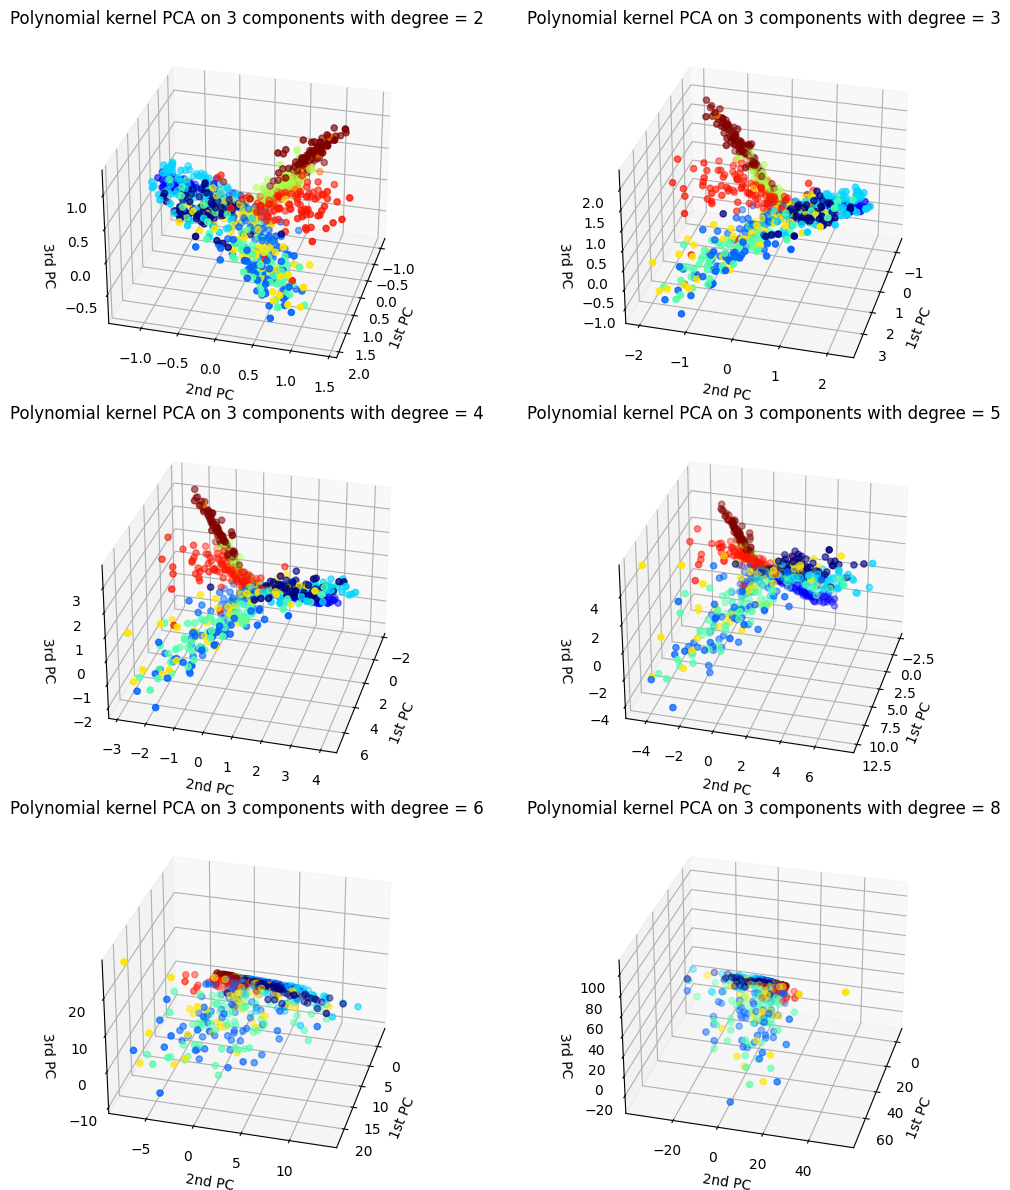

In [17]:
param_grid = [2,3,4,5,6,8]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), subplot_kw={'projection': '3d'})
camp = plt.get_cmap('jet', 10) #
axes = axes.flatten()

for i in range(len(param_grid)):
    kernel_pca = KernelPCA(n_components=3, kernel= 'poly' , degree = param_grid[i])
    X_new = kernel_pca.fit_transform(X_train_np)

    ax = axes[i]
    ax.scatter(X_new[:, 0], X_new[:, 1], X_new[:, 2], c=y_train_np, cmap=cmap)
    ax.view_init(30, 15)
    ax.set_title(f'Polynomial kernel PCA on 3 components with degree = {param_grid[i]}')
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    ax.set_zlabel('3rd PC')

fig.tight_layout()
plt.show()

Looking at the grid-scale, we can see that increase the degree corresponds to "strech" the data and understanding the geometry become more difficult. \
Focusing on low degree (up to $5$), we can see a pretty good separation, but still we have some problem: for example green-scale and light-blue-scale points are spread around.

### Isomap and t-SNE

Let's try another two algorithm that might be suitable for the dimensionality reduction purpose

#### Isomap

In [18]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=3, path_method='FW')
X_isomap = isomap.fit_transform(X_train_np)

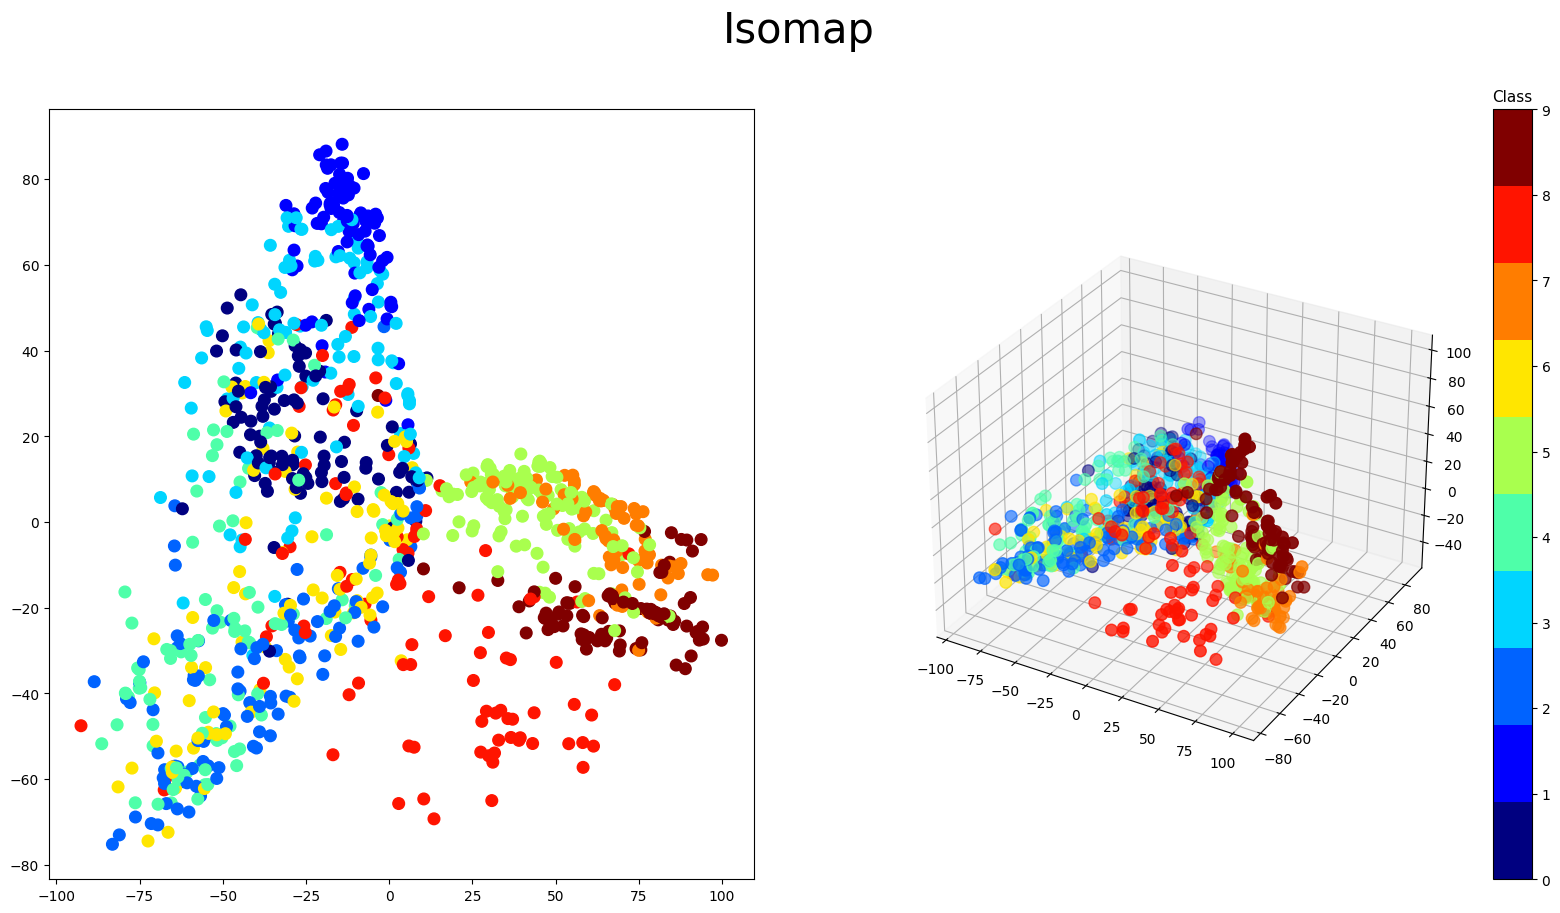

In [19]:
fig = plt.figure(figsize=(20,10))
cmap = plt.get_cmap('jet', 10)
fig.suptitle("Isomap", fontsize=30)
ax = fig.add_subplot(1,2,1)
ax.scatter(X_isomap[:,0], X_isomap[:,1], c=y_train_np, s=70, cmap = cmap)

ax = fig.add_subplot(1,2,2, projection='3d')
p = ax.scatter3D(X_isomap[:,0], X_isomap[:,1], X_isomap[:,2], c=y_train_np, s=70, cmap= cmap)

cb = plt.colorbar(p)
cb.ax.set_title('Class', fontsize=11)
plt.show()

#### t-SNE

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X_train_np)

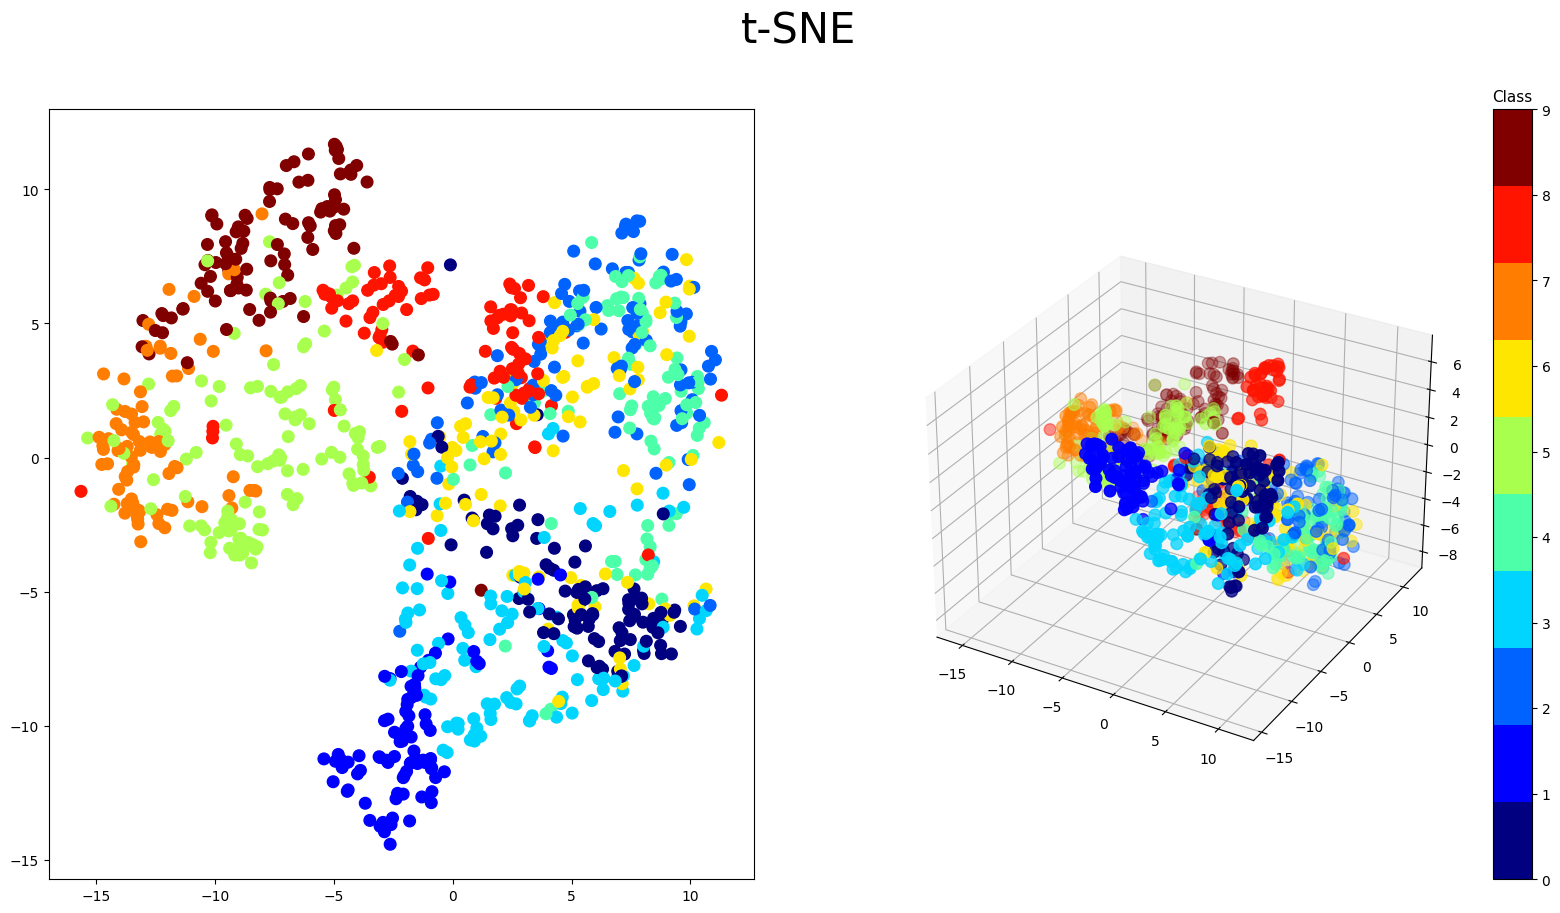

In [21]:
fig = plt.figure(figsize=(20,10))
cmap = plt.get_cmap('jet', 10)
fig.suptitle("t-SNE", fontsize=30)
ax = fig.add_subplot(1,2,1)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train_np, s=70, cmap= cmap)

ax = fig.add_subplot(1,2,2, projection='3d')
p = ax.scatter3D(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=y_train_np, s=70, cmap= cmap)

cb = plt.colorbar(p)
cb.ax.set_title('Class', fontsize=11)
plt.show()

## 2 - Clustering on 10-dimension Kernel PCA projection

- Choose a dimensionality reduction method which best separates the geometry of the data.
- Project the data on the first 10 components.
- Assign labels to the data ("unsupervised-mode assignation") according to `kemans`
- Three labels objects at the end of this section:
    - `y_train_np`: contain the true training labels
    - `y_pred`: contain the predicted labels by `kmeans`, but cluster $i$ is not guaranteed to match with class $i$
    - `mapped_labels`: contain the predicted labels by `kmeans`, reordered so that cluster $i$ match the class for which it has the majority of datapoints

- From previous analysis, gaussian kernel is better than polynomial. 
- By visualizing the projecetion, the best `gamma` are $0.0001$ and $0.001$. We choose the gaussian kernel with `gamma` = $0.0001$ beacuse it achieves the best `homogenity_score` and `completeness_score` (see below). 
- With this kernel PCA, we project the data onto the 10 principal components

In [22]:
from sklearn.decomposition import KernelPCA
# project on first 10 components
kernel_pca = KernelPCA(n_components=10, kernel= 'rbf' , gamma = 0.0001, eigen_solver= 'randomized', fit_inverse_transform=True) 
X_new = kernel_pca.fit_transform(X_train_np)

Let's see how images looks when we consider their 10 principal components.

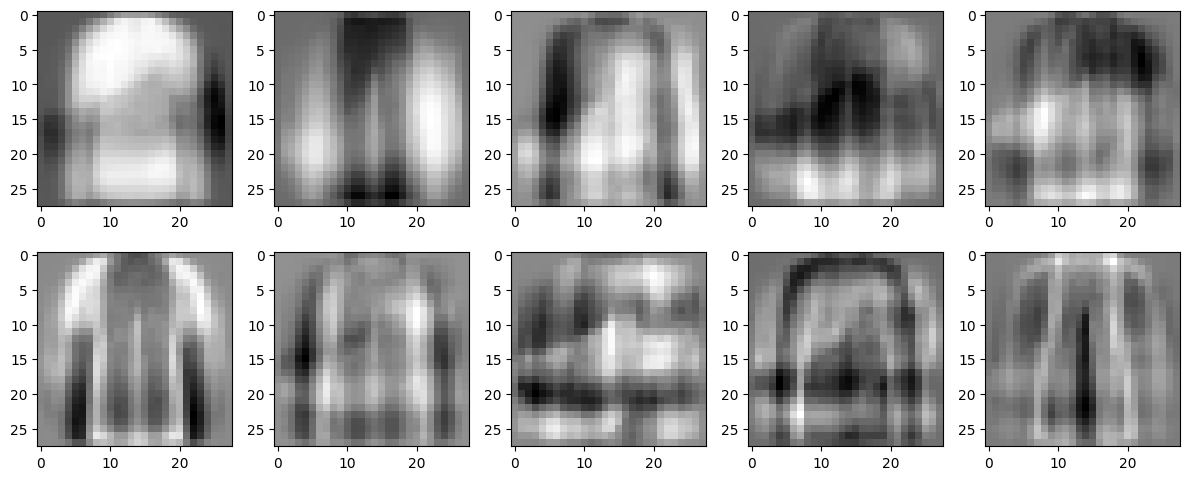

In [23]:
kpca_10 = [kernel_pca.X_transformed_fit_[i] for i in range(0,10)]
fig, axes=plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(pc_10[i], cmap='gray')
plt.tight_layout()
plt.show()

To assign 10 labels to the projected data, we rely on `kmeans` algorithm.

In [24]:
# clustering on X_new
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_new)

y_pred = kmeans.labels_

# y_pred contains labels assigned by kNN to each training point
# NB: kmeans.predict(X_new) == kmeans.labels_

Plot onto the first 2 principal components obtained by kernel PCA, with the labels obtained by kmeans.

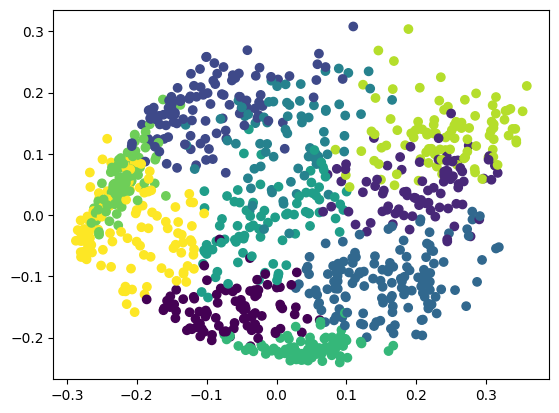

In [25]:
plt.scatter(X_new[:, 0], X_new[:, 1], c=kmeans.labels_)

To assess the projection and the clustering, the idea is to compare the label assigned from the `kmeans` algorithm to each data point with the true label stored inside `y_train`. \
Issue: there's no guarantee that the label assigned by `kmeans` algorithm match the true labels. Even if we are so lucky that the projection and `kmeans` algorithm perfects classify the data, it can happen that the $i$-th true label is mapped into the $j$-th cluster build by `kmeans` algorithm (in other words we can have a permutation of the classes). \
To assess the performances we use the `homogenity_score` and the `completeness_score`, which takes this into account. \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score

In [26]:
from sklearn.metrics import homogeneity_score, completeness_score

print('homogenity score: ', homogeneity_score(y_train_np, kmeans.labels_))
print('completeness_score: ', completeness_score(y_train_np, kmeans.labels_))

homogenity score:  0.48265462718465885
completeness_score:  0.48521730618758635


- With the following code is possible to match the clusters with the actual classes: for each cluster it is spotted the most frequent true label, and that label is then assigned to that cluster.
- `mapped_labels` contains the labels reordered to match with the true labels in `y_train_np`.
- There's still a problem concerning the performance of `kmeans`: it might happen that a true label, say $i$, is never the most frequent in each of the $10$ clusters. If this happen (and with a small batch this is pretty likely to happen), the `mapped_labels` will not contain any $i$ label, meaning that we "lose" class $i$.


In [27]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

mapped_labels = np.zeros_like(y_pred)
for i in range(10):
    mask=(y_pred==i)
    mapped_labels[mask] = mode(y_train_np[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/1285088800.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mapped_labels[mask] = mode(y_train_np[mask])[0]


The following line just to show that `homogeneity_score` and `completeness_score` don't change since they are mapping-label-independent

In [28]:
print('homogenity score: ', homogeneity_score(y_train_np, kmeans.labels_))
print('completeness_score: ', completeness_score(y_train_np, kmeans.labels_))

homogenity score:  0.48265462718465885
completeness_score:  0.48521730618758635


Build a confusion matrix with *before* the correct mapping: note that high value, expected to be on diagonal, are permutated.

Build a confusion matrix *after* the reordering of the labels: as expected, the higher value are almost all on the diagonal

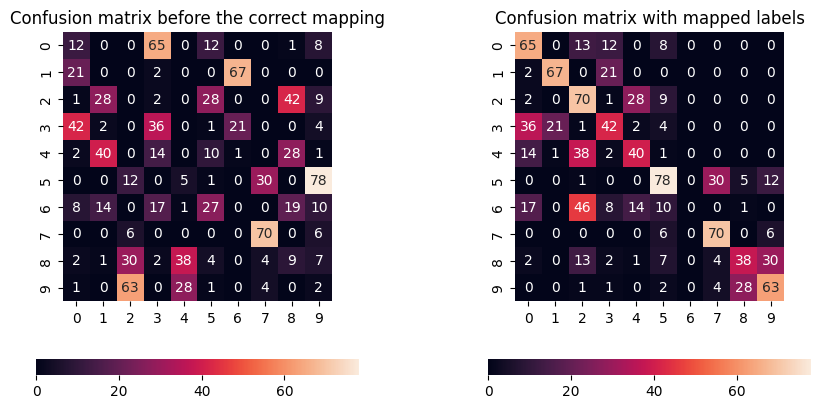

In [29]:
import seaborn as sns

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.heatmap(confusion_matrix(y_train_np, kmeans.predict(X_new)), square=True, annot=True, fmt='g', ax=ax1, cbar_kws={"orientation": "horizontal"})

sns.heatmap(confusion_matrix(y_train_np, mapped_labels), square=True, annot=True, fmt='g', ax=ax2, cbar_kws={"orientation": "horizontal"})

# Set the titles and axis labels for each subplot
ax1.set_title('Confusion matrix before the correct mapping')

ax2.set_title('Confusion matrix with mapped labels')


# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Show the figure
plt.show()


Let's see the kind of object we end up with inside each class fromed by kmean, using:
- we take the 9 random elements from the training set and:
    - see its true labels 
    - see its mapped_labels, coming from kNN after mapping
    - see its unmapped labels, coming directly from kNN

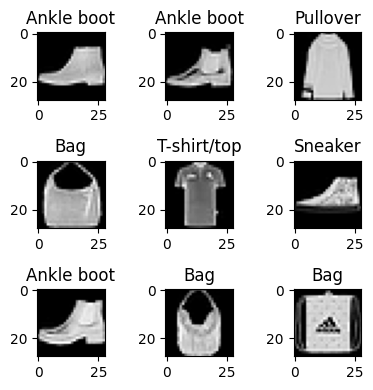

In [30]:
""" y_train, ie true labels"""
np.random.seed(1)
idxs = np.random.choice(X_train_np.shape[0], 9, False)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = X_train[idxs[i]].squeeze()
    label = y_train[idxs[i]]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{classes_names[label]}")
    
plt.tight_layout()
plt.show()


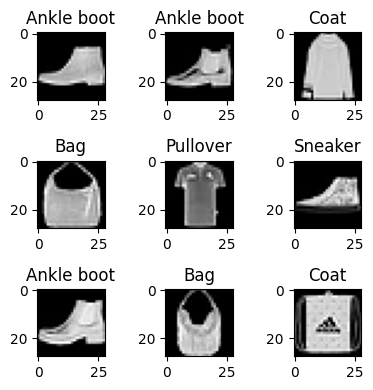

In [31]:
""" mapped_labeles, ie reordered labels"""
np.random.seed(1)
idxs = np.random.choice(X_train_np.shape[0], 9, False)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = X_train[idxs[i]].squeeze()
    label = mapped_labels[idxs[i]]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{classes_names[label]}")
    
plt.tight_layout()
plt.show()


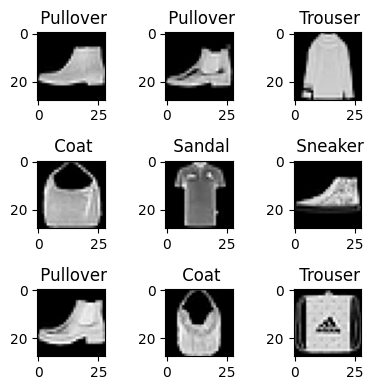

In [32]:
""" y_pred, ie unordered labels"""
np.random.seed(1)
idxs = np.random.choice(X_train_np.shape[0], 9, False)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = X_train[idxs[i]].squeeze()
    label = y_pred[idxs[i]]
    ax.imshow(img, cmap="gray")
    ax.set_title(f" {classes_names[label]}")
    
plt.tight_layout()
plt.show()

Analysis of the spectrum of the Gaussian Kernel PCA with `gamma` $=0.0001$, to see wether the number of components used before ($10$) is coherent with the elbow in the associated spectrum plot.

In [33]:
kernel_pca_complete = KernelPCA(n_components=X_train_np.shape[1], kernel= 'rbf' , gamma = 0.0001, eigen_solver= 'randomized')
kernel_pca_complete.fit(X_train_np)

KernelPCA(eigen_solver='randomized', gamma=0.0001, kernel='rbf',
          n_components=784)

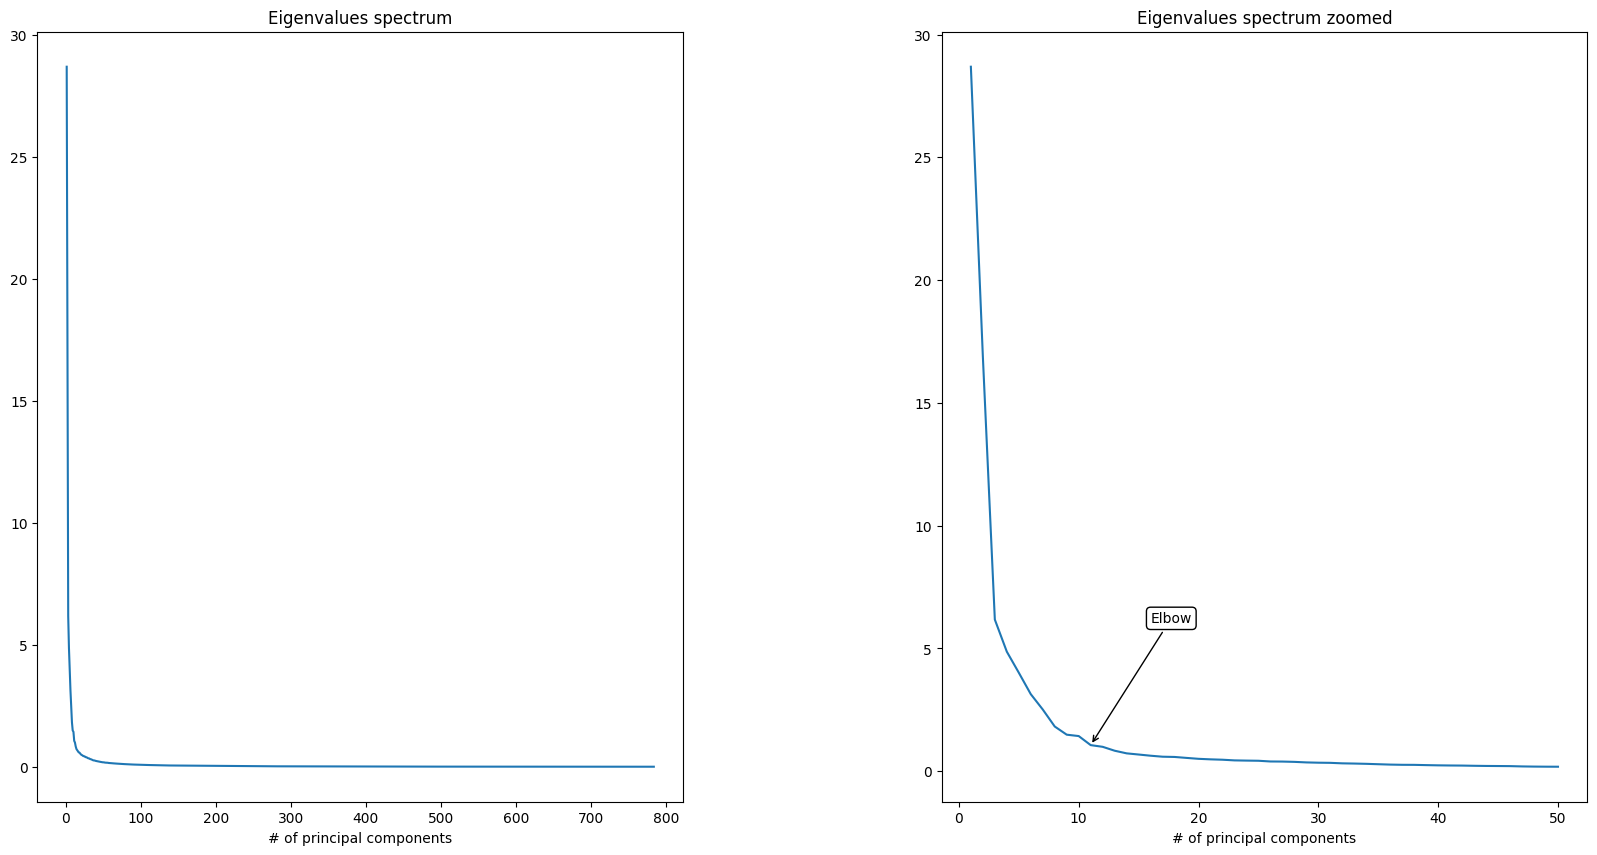

In [34]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))

# Plot the data on the subplots
ax1.plot(np.arange(1,785),kernel_pca_complete.eigenvalues_)
ax2.plot(np.arange(1,51),kernel_pca_complete.eigenvalues_[:50])

# Set the titles and axis labels for each subplot
ax1.set_title('Eigenvalues spectrum')
ax1.set_xlabel('# of principal components')
ax2.set_title('Eigenvalues spectrum zoomed')
ax2.set_xlabel('# of principal components')

el = 10
el_x = 10+1
el_y = kernel_pca_complete.eigenvalues_[el]
ax2.annotate('Elbow', xy = (el_x, el_y), 
             xytext=(el_x +5, el_y + 5),
             arrowprops = dict(facecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round', pad=0.3,facecolor='white', edgecolor='black'))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Show the figure
plt.show()


Analysis of only the first $50$ components to zoom-in and check if $10$ is coherent.

Actually around $10$ it can be spotted an elbow, meaning that the choice of $10$ principal components is coherent with the PCA eigenvalues spectrum.

## 3 - Supervised classification

The following cell is meant to recover from previous section:
-  `mapped_labels`: reordered labels from `kmeans` of type `np.array`
-  `y_pred`: unordered labels from `kmeans` of type `np.array`

In [35]:
"""The following code is to recover mapped_labels and y_pred, to run directly section 3.
"""
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans

kernel_pca = KernelPCA(n_components=10, kernel= 'rbf' , gamma = 0.0001, eigen_solver= 'randomized') 
X_new = kernel_pca.fit_transform(X_train_np)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_new)
y_pred = kmeans.labels_

from scipy.stats import mode


mapped_labels = np.zeros_like(y_pred)
for i in range(10):
    mask=(y_pred==i)
    mapped_labels[mask] = mode(y_train_np[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/4174206932.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mapped_labels[mask] = mode(y_train_np[mask])[0]


### Learn a SVM classifier 
Learn a gaussian kernel SVM using the label assigned in the previous step by `kmeans` algorithm. \
It is used `GridSearch` to tune the hyperparameters, and `balanced_accuracy` score to assess the classifier. \
The SVM is learned using:
1. the ordered training labels (mapped_labels) 
2. the unordered  training labels (y_pred): after this learning, we match the prediction, ie we map each label into the true one, as done before.
3. the true training labels (y_train)

We will notice that performance of 1. and 2. + matching is almost the same... that's why *names doesn't matter!*
Requirements to run:
-  `X_train`: features of type `np.array`
-  `mapped_labels`: reordered labels from `kmeans` of type `np.array`
-  `y_pred`: unordered labels from `kmeans` of type `np.array`

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {'kernel': ['rbf'],'C': np.logspace(-2, 5, 8), 'gamma' : np.logspace(-4, 3, 8)}
SVM_grid = GridSearchCV(SVC(), scoring = 'balanced_accuracy', param_grid = param_grid, cv = StratifiedKFold(n_splits = 3), n_jobs=4)
SVM_grid = SVM_grid.fit(X_train_np, y_pred)

# print best parameter
SVM_grid.best_estimator_

SVC(C=10.0, gamma=0.001)

Train the model with the best parameters obtained from before.

- Training feature: `X_train_np` 
- Training targets: `mapped_labels` 

In [37]:
from sklearn.svm import SVC
SVM = SVC(C=10, gamma=0.001) #selected as the best one from above
SVM = SVM.fit(X_train_np, mapped_labels)

Now use the test features `X_test` and the test targets `y_test` to see the accuracy of the trained model `SVM`. \
*Remark*: Inside `predicted` there are the predicted labels by the model on the test set `X_test`. Then those prediction are compared with the true test label `y_test`, to see the accuracy.

In [38]:
# now use the trained SVM model on test set, after a little preprocess (reshaping) of X_test (X_test is a tensor but ok... it works)
predicted = SVM.predict(X_test_np)

# accuracy fa schifo, ma perchè le classi sono cmq permutate...
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predicted)
print(accuracy)
metrics.balanced_accuracy_score(y_test, predicted)

0.4766666666666667


0.4993390970795689

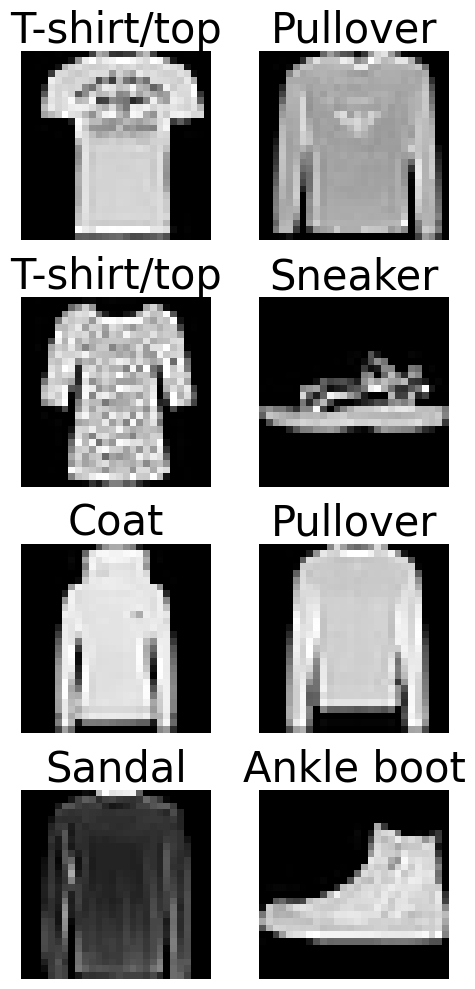

In [39]:
# see how perform SVM trained with mapped labels
n_row = 4
n_col = 2

n=n_row * n_col
images=X_train_p[:n]
labels = SVM.predict(images.reshape(n,784))

fig, axes=plt.subplots(n_row, n_col, figsize=(5,10))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}", fontsize=30)
    ax.axis('off')
plt.tight_layout()
fig.savefig('mapp.png')
plt.show()

Train the model with the unordered "messy" labels, coming from `y_pred`.
- Training feature: `X_train_np` 
- Training targets: `y_pred` 

In [40]:
from sklearn import metrics
SVM_fake = SVC(C=10, gamma=0.001) #selected as the best one from above
SVM_fake = SVM_fake.fit(X_train_np, y_pred)

predicted = SVM_fake.predict(X_test_np)

accuracy_messy = metrics.accuracy_score(y_test, predicted)
print(accuracy_messy)

0.14333333333333334


Now we match the predicted labels stored in "predicted" with the true label matching.
To do this we group the predicted label and see what is the most common true label inside each group.

In [41]:
svm_fake_labels = np.zeros_like(y_test)
for i in range(10):
    mask=(predicted==i)
    svm_fake_labels[mask] = mode(y_test[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/418535631.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  svm_fake_labels[mask] = mode(y_test[mask])[0]


Now we see how SVM trained with unmapped labels only performed, compared to how it performed when we reoreder the labels.

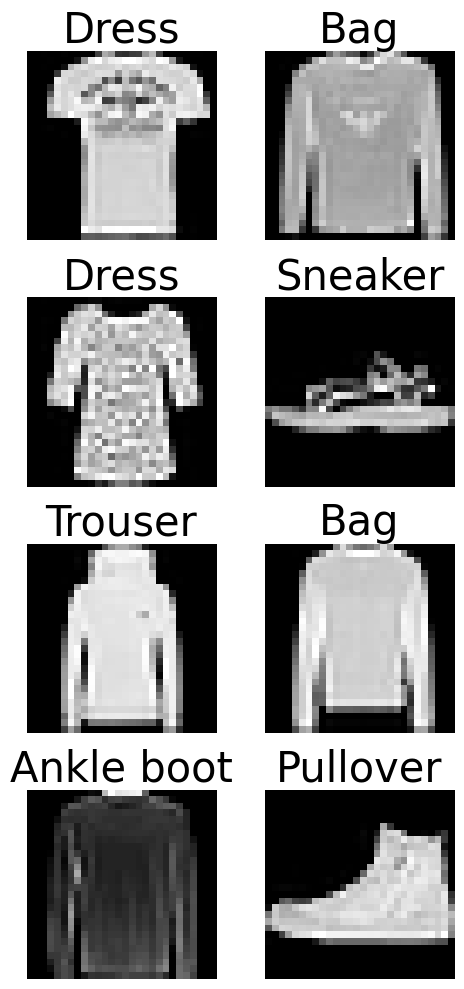

In [42]:
# see how perform SVM trained with unmapped labels only 
n_row = 4
n_col = 2

n=n_row * n_col
images=X_train_p[:n]
labels = SVM_fake.predict(images.reshape(n,784))

fig, axes=plt.subplots(n_row, n_col, figsize=(5,10))
#plt.suptitle('SVM with kmean labels not reoreder')
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}", fontsize=30)
    ax.axis('off')
plt.tight_layout()
fig.savefig('unmap.png')
plt.show()

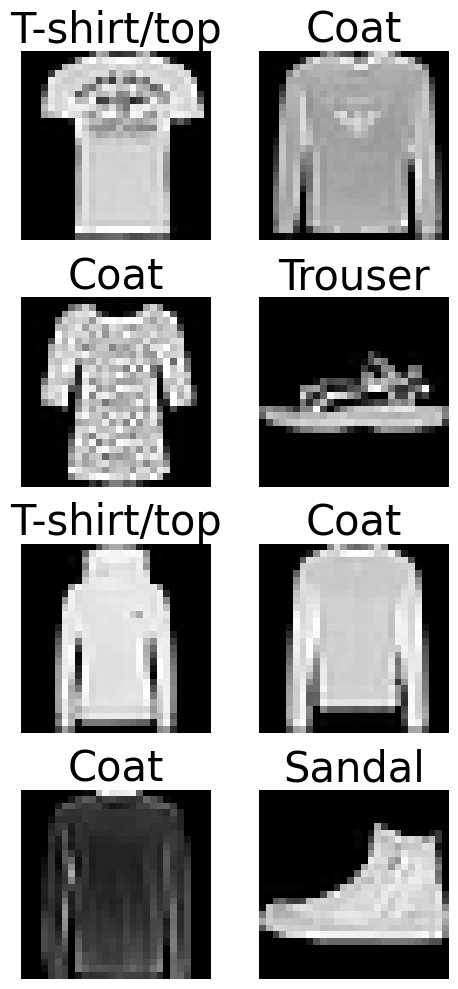

In [43]:
# see how perform SVM trained with unmapped labels, then reordered
n_row = 4
n_col = 2

n=n_row * n_col
images=X_train_p[:n]
labels = svm_fake_labels

fig, axes=plt.subplots(n_row, n_col, figsize=(5,10))
#plt.suptitle('SVM with kmean labels not reoreder')
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}", fontsize=30)
    ax.axis('off')
plt.tight_layout()
fig.savefig('un_re.png')
plt.show()

- y_pred: unordered labels assigned by kNN
- predicted_label: predicted label by SVM starting from X_test
- y_test: true test label
- svm_fake_labels: predicted_label rematched

After reordering, accuracy is almost 50%, against 14%. Furthermore, note that with 'mapped_labels' acuuracy was 48%.

In [44]:
metrics.accuracy_score(y_test, svm_fake_labels)

0.49333333333333335

Train with the true labels, coming from `y_train_np`. 
- Training feature: `X_train_np` 
- Training targets: `y_train_np` 

In [45]:
from sklearn import metrics
SVM_true = SVC(C=10, gamma=0.001) #selected as the best one from above
SVM_true = SVM_true.fit(X_train_np, y_train_np)

predicted_label = SVM_true.predict(X_test_np)

accuracy_true =metrics.accuracy_score(y_test, predicted_label)
print(accuracy_true)

0.7866666666666666


In [46]:
from IPython.display import Markdown

markdown_str = f"As expected, accuracy is much more low now: only ${accuracy_messy*100} \%$ against ${accuracy*100} \%$ we had we the 'correct' labels mapping. With the true labels, we have ${accuracy_true*100} \%$ "

display(Markdown(markdown_str))

As expected, accuracy is much more low now: only $14.333333333333334 \%$ against $47.66666666666667 \%$ we had we the 'correct' labels mapping. With the true labels, we have $78.66666666666666 \%$ 

Now we see how SVM trained with ground-truth labels performs.

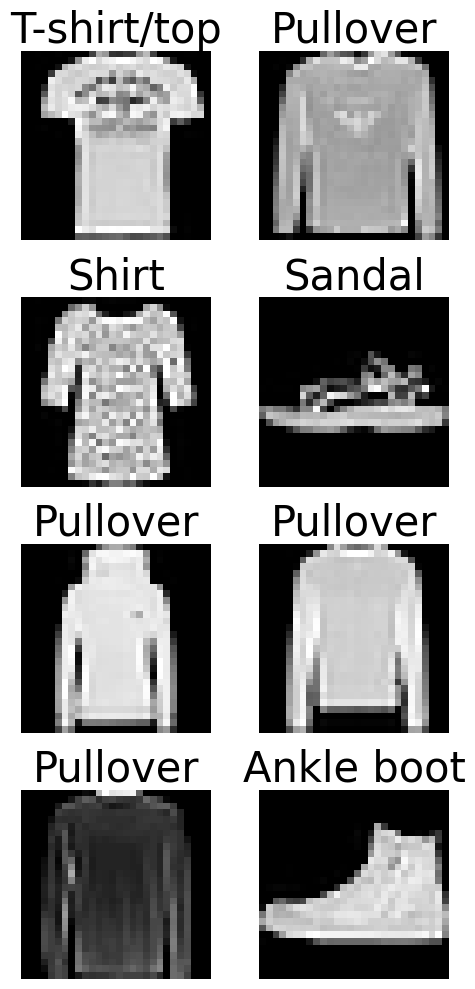

In [47]:
# see how perform SVM_true
n_row = 4
n_col = 2

n=n_row * n_col
images=X_train_p[:n]

labels = SVM_true.predict(images.reshape(n,784))
fig, axes = plt.subplots(n_row, n_col, figsize=(5,10))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}", fontsize=30)
    ax.axis('off')
plt.tight_layout()
fig.savefig('true.png')
plt.show()

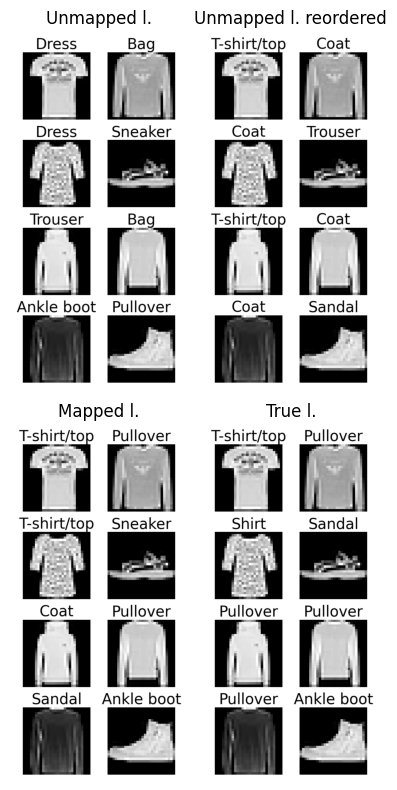

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Load images
img1 = plt.imread("unmap.png")
img2 = plt.imread("un_re.png")
img3 = plt.imread("mapp.png")
img4 = plt.imread("true.png")

# Create figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4,8))

# Plot images on subplots
axes[0,0].set_title('Unmapped l.')
axes[0,0].imshow(img1)
axes[0,0].axis('off')

axes[0,1].set_title('Unmapped l. reordered')
axes[0,1].imshow(img2)
axes[0,1].axis('off')

axes[1,0].set_title('Mapped l.')
axes[1,0].imshow(img3)
axes[1,0].axis('off')

axes[1,1].set_title('True l.')
axes[1,1].imshow(img4)
axes[1,1].axis('off')

# Show figure
plt.tight_layout()
fig.savefig('final.png')
plt.show()

### Learn a fully-connected NN

Learn a fully connected NN using the labels assigned in the previous step by `kmeans` algorithm. \
The network is trained using both the ordered and the unordered set of training labels, to compare the results. \
Requirements to run:
-  `X_train`: features of type `torch.Tensor`
-  `mapped_labels`: reordered labels from `kmeans` of type `np.array`
-  `y_pred`: unordered labels from `kmeans` of type `np.array`
- `X_train_neural`, to perform SDG

Transform `y_pred` and `mapped_labels` into `torch.Tensor` objects

In [49]:
import torch.nn.init as init

# Define an initialization function to set the weights and biases to zero
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.zeros_(m.weight)
        init.zeros_(m.bias)




In [50]:
y_pred_tensor = th.from_numpy(y_pred)
mapped_labels_tensor = th.from_numpy(mapped_labels)

#### Define and train a fully connected network in the 3 different scenarios: FCNN1

In [51]:
import torch.nn as nn
import torch.optim as optim

# Define a neural network class
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Define a neural network model
model = FashionMNISTNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
num_epochs = 30

Train on the dataset without unsupervised part.

In [53]:
# Train on dataset "giusto":
total_test_accuracy = []
total_test_loss = []
for epoch in range(num_epochs):
    # Train
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    # Compute accuracy
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for data, target in test_loader:
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    total_test_loss.append(test_loss)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    total_test_accuracy.append(test_accuracy)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.192, Test accuracy: 55.000%
Epoch 1, Test loss: 0.185, Test accuracy: 60.333%
Epoch 2, Test loss: 0.182, Test accuracy: 66.333%
Epoch 3, Test loss: 0.179, Test accuracy: 67.667%
Epoch 4, Test loss: 0.180, Test accuracy: 67.000%
Epoch 5, Test loss: 0.181, Test accuracy: 64.333%
Epoch 6, Test loss: 0.177, Test accuracy: 69.667%
Epoch 7, Test loss: 0.177, Test accuracy: 70.000%
Epoch 8, Test loss: 0.177, Test accuracy: 69.667%
Epoch 9, Test loss: 0.176, Test accuracy: 69.667%
Epoch 10, Test loss: 0.179, Test accuracy: 67.000%
Epoch 11, Test loss: 0.176, Test accuracy: 70.000%
Epoch 12, Test loss: 0.175, Test accuracy: 71.000%
Epoch 13, Test loss: 0.176, Test accuracy: 69.667%
Epoch 14, Test loss: 0.176, Test accuracy: 70.667%
Epoch 15, Test loss: 0.176, Test accuracy: 70.333%
Epoch 16, Test loss: 0.176, Test accuracy: 71.000%
Epoch 17, Test loss: 0.176, Test accuracy: 69.667%
Epoch 18, Test loss: 0.176, Test accuracy: 69.667%
Epoch 19, Test loss: 0.177, Test accuracy

In [54]:
# see the predicted class for the test set
th.argmax(model(X_test), dim=1)

tensor([3, 4, 4, 1, 0, 2, 4, 5, 9, 4, 9, 5, 0, 0, 9, 1, 8, 0, 5, 8, 9, 2, 5, 4,
        0, 4, 0, 2, 5, 3, 5, 4, 9, 1, 9, 2, 2, 2, 5, 3, 5, 8, 0, 4, 9, 0, 0, 3,
        9, 1, 2, 0, 6, 0, 2, 5, 2, 4, 5, 8, 9, 8, 2, 1, 6, 2, 1, 0, 1, 5, 3, 2,
        9, 8, 8, 5, 4, 2, 3, 0, 8, 0, 3, 8, 5, 8, 8, 9, 5, 3, 4, 0, 2, 1, 4, 5,
        4, 0, 5, 3, 3, 9, 9, 2, 2, 0, 1, 3, 0, 2, 4, 0, 4, 1, 0, 5, 5, 5, 4, 6,
        4, 5, 3, 0, 4, 3, 0, 4, 4, 0, 2, 9, 0, 5, 3, 3, 5, 1, 2, 9, 5, 8, 3, 4,
        1, 9, 4, 0, 8, 5, 6, 1, 9, 8, 0, 1, 3, 9, 0, 8, 8, 9, 3, 2, 8, 5, 9, 8,
        4, 3, 0, 4, 9, 8, 5, 0, 4, 3, 2, 6, 5, 5, 1, 2, 2, 0, 0, 0, 6, 3, 3, 4,
        6, 3, 0, 8, 5, 4, 5, 9, 6, 8, 3, 4, 2, 8, 2, 9, 5, 4, 6, 3, 0, 5, 3, 1,
        4, 0, 8, 9, 2, 4, 8, 8, 8, 4, 5, 9, 8, 4, 4, 4, 5, 1, 4, 4, 0, 0, 0, 4,
        9, 6, 5, 5, 9, 1, 0, 0, 8, 1, 9, 8, 1, 3, 4, 0, 3, 1, 2, 8, 1, 5, 8, 5,
        4, 5, 3, 1, 8, 1, 4, 5, 2, 8, 9, 4, 9, 8, 0, 6, 9, 4, 3, 1, 5, 5, 4, 1,
        4, 8, 3, 4, 3, 1, 4, 4, 2, 1, 0,

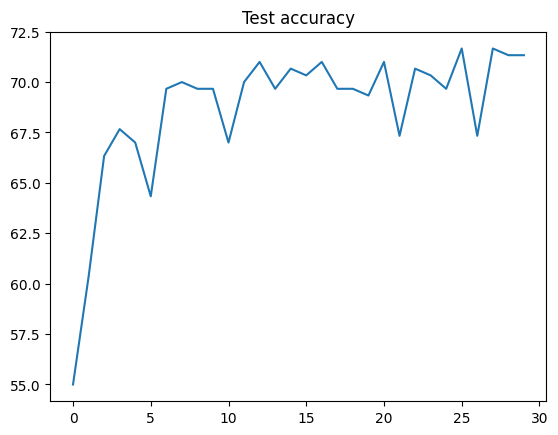

In [55]:
plt.plot(np.arange(30), total_test_accuracy)
plt.title('Test accuracy')
plt.show()

Train the net on dataset with labels coming directly from kmeans (unampped labels):

Define a new train loader, using y_pred as training labels

In [56]:
BATCH_SIZE = 10
train_loader_fake = DataLoader(dataset=list(zip(X_train, y_pred)), batch_size=BATCH_SIZE, shuffle=True)
test_loader_fake = DataLoader(dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True)

In [57]:
model.apply(init_weights)
# Train on dataset with unordered_labels:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_fake):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        
        # retrive the index 
        #batch_sampler = train_loader.batch_sampler
        #batch_indices = list(iter(batch_sampler))[0]

        # set as target the of each datapoint in the batch the class determined by kmeans, using unmapped_labels, i.e y_pred
        #target = y_pred_tensor[batch_indices]

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            
            # use the model to predict
            output = model(data)

            # retrive the index 
            #batch_sampler = test_loader.batch_sampler
            #batch_indices = list(iter(batch_sampler))[batch_idx]
            # set as target the of each datapoint in the batch the class determined by kmeans
            #target = y_pred_tensor[batch_indices]
            #target = target.to(th.int64)


            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.229, Test accuracy: 15.333%
Epoch 1, Test loss: 0.231, Test accuracy: 14.000%
Epoch 2, Test loss: 0.230, Test accuracy: 15.333%
Epoch 3, Test loss: 0.232, Test accuracy: 13.667%
Epoch 4, Test loss: 0.231, Test accuracy: 15.333%
Epoch 5, Test loss: 0.232, Test accuracy: 13.667%
Epoch 6, Test loss: 0.232, Test accuracy: 13.667%
Epoch 7, Test loss: 0.231, Test accuracy: 15.333%
Epoch 8, Test loss: 0.231, Test accuracy: 15.000%
Epoch 9, Test loss: 0.231, Test accuracy: 14.667%
Epoch 10, Test loss: 0.231, Test accuracy: 15.333%
Epoch 11, Test loss: 0.232, Test accuracy: 13.667%
Epoch 12, Test loss: 0.231, Test accuracy: 15.333%
Epoch 13, Test loss: 0.231, Test accuracy: 14.667%
Epoch 14, Test loss: 0.231, Test accuracy: 15.000%
Epoch 15, Test loss: 0.231, Test accuracy: 14.667%
Epoch 16, Test loss: 0.231, Test accuracy: 14.667%
Epoch 17, Test loss: 0.231, Test accuracy: 15.667%
Epoch 18, Test loss: 0.231, Test accuracy: 14.667%
Epoch 19, Test loss: 0.230, Test accuracy

In [58]:
# see the predicted class for the test set
th.argmax(model(X_test), dim=1)

tensor([3, 8, 8, 6, 3, 8, 8, 9, 7, 5, 7, 9, 9, 9, 7, 3, 7, 5, 7, 7, 4, 8, 7, 3,
        3, 8, 3, 8, 7, 9, 7, 5, 2, 6, 2, 8, 9, 5, 9, 0, 9, 4, 3, 8, 2, 3, 3, 3,
        4, 0, 8, 9, 4, 3, 8, 7, 5, 5, 9, 2, 9, 4, 8, 6, 9, 5, 0, 3, 6, 9, 0, 8,
        7, 2, 4, 9, 4, 8, 0, 5, 4, 3, 5, 7, 7, 8, 4, 7, 7, 6, 5, 3, 5, 6, 5, 9,
        4, 3, 7, 3, 3, 7, 2, 5, 8, 0, 6, 3, 3, 8, 8, 9, 8, 6, 3, 9, 7, 7, 8, 0,
        4, 0, 3, 3, 4, 0, 3, 8, 3, 3, 8, 4, 9, 9, 0, 0, 2, 0, 9, 7, 7, 4, 0, 8,
        6, 2, 3, 0, 4, 7, 5, 6, 4, 8, 3, 6, 6, 4, 3, 2, 7, 7, 3, 5, 2, 4, 2, 4,
        8, 3, 3, 3, 7, 2, 7, 9, 8, 0, 8, 5, 7, 7, 0, 8, 5, 3, 3, 0, 8, 0, 0, 3,
        4, 0, 3, 9, 9, 5, 9, 2, 5, 2, 6, 8, 8, 2, 5, 2, 7, 5, 3, 0, 3, 9, 0, 0,
        3, 3, 9, 2, 5, 3, 8, 4, 4, 8, 9, 7, 2, 4, 3, 4, 9, 6, 5, 3, 3, 3, 3, 8,
        2, 5, 7, 7, 7, 6, 3, 3, 4, 6, 2, 2, 3, 0, 8, 0, 3, 6, 8, 7, 6, 9, 2, 7,
        5, 7, 3, 6, 2, 6, 3, 7, 5, 4, 2, 4, 7, 0, 3, 5, 2, 9, 0, 0, 9, 9, 8, 0,
        4, 7, 6, 8, 3, 3, 3, 5, 5, 0, 3,

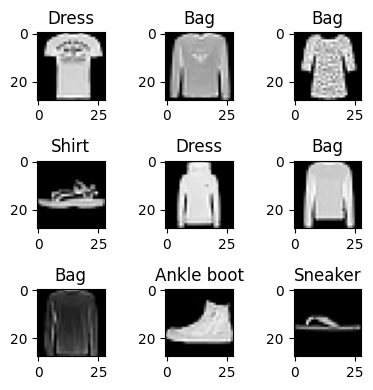

In [59]:
# see how perform the net befor reordering/rematching
n_row = 3
n_col = 3

n=n_row * n_col
images=X_train[:n]
images = images.reshape(n,28,28)

labels = np.array(th.argmax(model(X_test), dim=1))
fig, axes=plt.subplots(n_row, n_col, figsize=(4,4))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

Reorder/ match the labels

In [60]:
predicted_labels = np.array(th.argmax(model(X_test), dim=1))

In [61]:
fcnn_fake_labels = np.zeros_like(y_test)
for i in range(10):
    mask=(predicted_labels==i)
    fcnn_fake_labels[mask] = mode(y_test[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/2860629643.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  fcnn_fake_labels[mask] = mode(y_test[mask])[0]


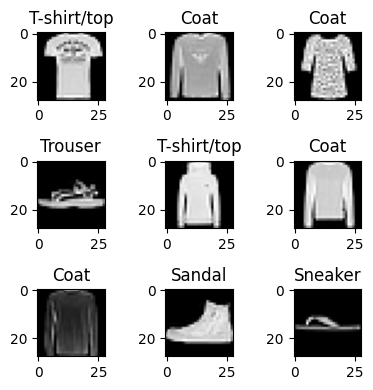

In [62]:
# see how performance of this training after reorderng the labels
n_row = 3
n_col = 3

n=n_row * n_col
images=X_train[:n]
images = images.reshape(n,28,28)

labels = fcnn_fake_labels
fig, axes=plt.subplots(n_row, n_col, figsize=(4,4))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

**compute the accuracy after the reordering**

In [63]:
# compute the accuracy after the reordering:
metrics.accuracy_score(y_test,  fcnn_fake_labels)

0.4666666666666667

We see that the accuracy after reordering is 51%, much higher than 14% and similar to the test accuracy computed with the training n mapped labels (~45%)... *names doesn't matter!*

In [64]:
batch_sampler = test_loader.batch_sampler
batch_indices = list(iter(batch_sampler))
np.array(batch_indices).shape # 30* 10 = 300 = test set

# 30 è quel numero K di iterazioni tale che K*bathsize = test set

(30, 10)

In [65]:
batch_sampler = train_loader.batch_sampler
batch_indices = list(iter(batch_sampler))
np.array(batch_indices).shape # 100 * 10 = 1000 = training set

# 100 è quel numero K di iterazioni tale che K*bathsize = training set

(100, 10)

Train the model with mapped labels... we might recover something similar to the training of the net with unmapped labels, then reordered... * names doesn't matter!*

In [66]:
# define a new dataloader for mapped labels
BATCH_SIZE = 10
train_loader_map = DataLoader(dataset=list(zip(X_train, mapped_labels)), batch_size=BATCH_SIZE, shuffle=True)
test_loader_map = DataLoader(dataset=list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=True)

In [67]:
model.apply(init_weights)
# Train on dataset with mapped_labels:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_map):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_map):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)

            # use the model to predict
            output = model(data)

    
            test_loss += criterion(output, target.long())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.201, Test accuracy: 44.000%
Epoch 1, Test loss: 0.202, Test accuracy: 43.000%
Epoch 2, Test loss: 0.201, Test accuracy: 44.333%
Epoch 3, Test loss: 0.201, Test accuracy: 44.667%
Epoch 4, Test loss: 0.202, Test accuracy: 44.000%
Epoch 5, Test loss: 0.203, Test accuracy: 43.667%
Epoch 6, Test loss: 0.201, Test accuracy: 44.333%
Epoch 7, Test loss: 0.202, Test accuracy: 43.667%
Epoch 8, Test loss: 0.201, Test accuracy: 44.667%
Epoch 9, Test loss: 0.203, Test accuracy: 42.333%
Epoch 10, Test loss: 0.202, Test accuracy: 44.333%
Epoch 11, Test loss: 0.201, Test accuracy: 44.000%
Epoch 12, Test loss: 0.202, Test accuracy: 44.000%
Epoch 13, Test loss: 0.202, Test accuracy: 44.000%
Epoch 14, Test loss: 0.201, Test accuracy: 44.000%
Epoch 15, Test loss: 0.201, Test accuracy: 44.333%
Epoch 16, Test loss: 0.201, Test accuracy: 45.333%
Epoch 17, Test loss: 0.202, Test accuracy: 44.000%
Epoch 18, Test loss: 0.201, Test accuracy: 45.667%
Epoch 19, Test loss: 0.201, Test accuracy

In [68]:
th.argmax(model(X_test), dim=1)

tensor([0, 2, 2, 1, 0, 2, 2, 5, 7, 2, 7, 5, 5, 5, 7, 0, 7, 2, 7, 7, 8, 2, 7, 0,
        0, 2, 0, 2, 7, 5, 7, 2, 9, 1, 9, 2, 5, 2, 5, 3, 5, 8, 0, 2, 9, 0, 0, 0,
        8, 3, 2, 5, 2, 0, 2, 7, 2, 2, 5, 9, 5, 8, 2, 1, 5, 0, 3, 0, 1, 5, 3, 2,
        7, 9, 8, 5, 0, 2, 3, 3, 8, 0, 2, 7, 7, 2, 8, 7, 7, 1, 2, 0, 2, 1, 2, 5,
        2, 0, 7, 0, 0, 7, 9, 2, 2, 3, 1, 0, 0, 2, 2, 5, 2, 1, 0, 5, 7, 7, 2, 3,
        2, 3, 0, 0, 0, 3, 0, 2, 0, 0, 2, 8, 5, 5, 3, 3, 9, 3, 5, 7, 7, 8, 3, 2,
        1, 9, 0, 0, 8, 7, 2, 1, 8, 2, 0, 1, 1, 8, 0, 9, 7, 7, 0, 2, 9, 5, 9, 8,
        2, 0, 0, 0, 7, 9, 9, 5, 2, 3, 2, 2, 7, 7, 3, 2, 2, 0, 0, 5, 2, 3, 3, 0,
        0, 3, 0, 9, 5, 0, 5, 9, 2, 9, 1, 2, 2, 8, 2, 9, 7, 2, 0, 3, 2, 5, 3, 3,
        0, 0, 5, 9, 2, 0, 2, 8, 8, 2, 5, 7, 9, 2, 0, 0, 5, 1, 2, 0, 0, 0, 0, 2,
        9, 2, 7, 7, 9, 1, 0, 0, 8, 1, 9, 9, 0, 3, 2, 3, 0, 1, 2, 7, 1, 5, 9, 7,
        2, 7, 0, 1, 9, 1, 0, 7, 2, 8, 9, 2, 7, 3, 0, 2, 9, 5, 3, 3, 5, 5, 2, 3,
        2, 7, 1, 2, 0, 0, 0, 0, 2, 3, 0,

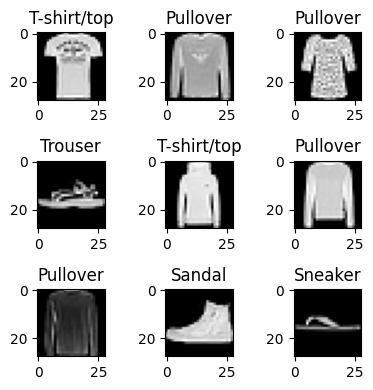

In [69]:
# see how performance the training with mapped_labels 
n_row = 3
n_col = 3

n=n_row * n_col
images=X_train[:n]
images = images.reshape(n,28,28)

labels = np.array(th.argmax(model(X_test), dim=1))
fig, axes=plt.subplots(n_row, n_col, figsize=(4,4))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

#### Define and train a fully connected network in the 3 different scenarios: FCNN2

In [70]:
class FashionMNISTNet_1(nn.Module):
    def __init__(self):
        super(FashionMNISTNet_1, self).__init__()
        self.flatten = nn.Flatten()
        self.lin = nn.Sequential(nn.Linear(784,256),
                                nn.LeakyReLU(),
                                nn.Linear(256,10),
                                )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.lin(x)
        #print(x.shape)
        # Softmax computation
        x = self.softmax(x)
        return x

In [71]:
# Define a neural network model
model = FashionMNISTNet_1()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
# Train on dataset "giusto":
model.apply(init_weights)
for epoch in range(30):
    # Train
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    # Compute accuracy
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for data, target in test_loader:
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.230, Test accuracy: 10.000%
Epoch 1, Test loss: 0.230, Test accuracy: 10.000%
Epoch 2, Test loss: 0.230, Test accuracy: 10.000%
Epoch 3, Test loss: 0.230, Test accuracy: 10.000%
Epoch 4, Test loss: 0.230, Test accuracy: 10.000%
Epoch 5, Test loss: 0.230, Test accuracy: 10.000%
Epoch 6, Test loss: 0.230, Test accuracy: 10.000%
Epoch 7, Test loss: 0.230, Test accuracy: 10.000%
Epoch 8, Test loss: 0.230, Test accuracy: 10.000%
Epoch 9, Test loss: 0.230, Test accuracy: 10.000%
Epoch 10, Test loss: 0.230, Test accuracy: 10.000%
Epoch 11, Test loss: 0.230, Test accuracy: 10.000%
Epoch 12, Test loss: 0.230, Test accuracy: 10.000%
Epoch 13, Test loss: 0.230, Test accuracy: 10.000%
Epoch 14, Test loss: 0.230, Test accuracy: 10.000%
Epoch 15, Test loss: 0.230, Test accuracy: 10.000%
Epoch 16, Test loss: 0.230, Test accuracy: 10.000%
Epoch 17, Test loss: 0.230, Test accuracy: 10.000%
Epoch 18, Test loss: 0.230, Test accuracy: 10.000%
Epoch 19, Test loss: 0.230, Test accuracy

In [73]:
# Train on dataset with mapped_labels:
model.apply(init_weights)
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_map):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)


        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_map):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)

            # use the model to predict
            output = model(data)

           

            test_loss += criterion(output, target.long())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.230, Test accuracy: 8.667%
Epoch 1, Test loss: 0.230, Test accuracy: 8.667%
Epoch 2, Test loss: 0.230, Test accuracy: 8.667%
Epoch 3, Test loss: 0.230, Test accuracy: 8.667%
Epoch 4, Test loss: 0.230, Test accuracy: 8.667%
Epoch 5, Test loss: 0.231, Test accuracy: 8.667%
Epoch 6, Test loss: 0.231, Test accuracy: 8.667%
Epoch 7, Test loss: 0.231, Test accuracy: 8.667%
Epoch 8, Test loss: 0.231, Test accuracy: 8.667%
Epoch 9, Test loss: 0.231, Test accuracy: 8.667%
Epoch 10, Test loss: 0.231, Test accuracy: 8.667%
Epoch 11, Test loss: 0.231, Test accuracy: 8.667%
Epoch 12, Test loss: 0.231, Test accuracy: 8.667%
Epoch 13, Test loss: 0.231, Test accuracy: 8.667%
Epoch 14, Test loss: 0.231, Test accuracy: 8.667%
Epoch 15, Test loss: 0.231, Test accuracy: 8.667%
Epoch 16, Test loss: 0.231, Test accuracy: 8.667%
Epoch 17, Test loss: 0.231, Test accuracy: 8.667%
Epoch 18, Test loss: 0.231, Test accuracy: 8.667%
Epoch 19, Test loss: 0.231, Test accuracy: 8.667%
Epoch 20, 

In [74]:
# Train on dataset with unordered_labels:
model.apply(init_weights)
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_fake):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        
     

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_fake):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            
            # use the model to predict
            output = model(data)

            test_loss += criterion(output, target.long())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.230, Test accuracy: 8.667%
Epoch 1, Test loss: 0.230, Test accuracy: 8.667%
Epoch 2, Test loss: 0.230, Test accuracy: 8.667%
Epoch 3, Test loss: 0.230, Test accuracy: 8.667%
Epoch 4, Test loss: 0.230, Test accuracy: 8.667%
Epoch 5, Test loss: 0.231, Test accuracy: 8.667%
Epoch 6, Test loss: 0.231, Test accuracy: 8.667%
Epoch 7, Test loss: 0.231, Test accuracy: 8.667%
Epoch 8, Test loss: 0.231, Test accuracy: 8.667%
Epoch 9, Test loss: 0.231, Test accuracy: 8.667%
Epoch 10, Test loss: 0.231, Test accuracy: 8.667%
Epoch 11, Test loss: 0.231, Test accuracy: 8.667%
Epoch 12, Test loss: 0.231, Test accuracy: 8.667%
Epoch 13, Test loss: 0.231, Test accuracy: 8.667%
Epoch 14, Test loss: 0.231, Test accuracy: 8.667%
Epoch 15, Test loss: 0.231, Test accuracy: 8.667%
Epoch 16, Test loss: 0.231, Test accuracy: 8.667%
Epoch 17, Test loss: 0.231, Test accuracy: 8.667%
Epoch 18, Test loss: 0.231, Test accuracy: 8.667%
Epoch 19, Test loss: 0.231, Test accuracy: 8.667%
Epoch 20, 

In [75]:
predicted_labels = np.array(th.argmax(model(X_test), dim=1))
cnn_fake_labels = np.zeros_like(y_test)
for i in range(10):
    mask=(predicted_labels==i)
    cnn_fake_labels[mask] = mode(y_test[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/1392135184.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  cnn_fake_labels[mask] = mode(y_test[mask])[0]


In [76]:
metrics.accuracy_score(y_test, cnn_fake_labels)

0.15

#### Define and train a convolutional neural network in the 3 different scenarios

In [77]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


In [78]:
class FashionMNISTConvNet(nn.Module):
    def __init__(self):
        super(FashionMNISTConvNet, self).__init__()
        

        self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, stride=1),
                                  nn.LeakyReLU(),
                                  nn.AvgPool2d(kernel_size=2),
                                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1),
                                  nn.LeakyReLU(),
                                  nn.AvgPool2d(kernel_size=2),
                                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1),
                                  nn.LeakyReLU(),
                                  nn.AvgPool2d(kernel_size=2),
                                  nn.Flatten(1))

    
        self.lin = nn.Linear(256,10)


    def forward(self, x):
        
        x = self.lin(self.conv(x))
        # Softmax computation
        out = F.softmax(x, dim=1)

        return out

In [79]:
# Define a neural network model
model = FashionMNISTConvNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
# Train on dataset "giusto":
model.apply(init_weights)
for epoch in range(50):
    # Train
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    # Compute accuracy
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for data, target in test_loader:
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.200, Test accuracy: 49.333%
Epoch 1, Test loss: 0.194, Test accuracy: 51.333%
Epoch 2, Test loss: 0.192, Test accuracy: 54.333%
Epoch 3, Test loss: 0.190, Test accuracy: 57.000%
Epoch 4, Test loss: 0.193, Test accuracy: 53.000%
Epoch 5, Test loss: 0.191, Test accuracy: 55.667%
Epoch 6, Test loss: 0.186, Test accuracy: 60.667%
Epoch 7, Test loss: 0.186, Test accuracy: 61.000%
Epoch 8, Test loss: 0.185, Test accuracy: 61.667%
Epoch 9, Test loss: 0.185, Test accuracy: 61.667%
Epoch 10, Test loss: 0.189, Test accuracy: 57.000%
Epoch 11, Test loss: 0.183, Test accuracy: 64.667%
Epoch 12, Test loss: 0.187, Test accuracy: 58.667%
Epoch 13, Test loss: 0.181, Test accuracy: 66.667%
Epoch 14, Test loss: 0.180, Test accuracy: 66.000%
Epoch 15, Test loss: 0.181, Test accuracy: 64.667%
Epoch 16, Test loss: 0.181, Test accuracy: 64.333%
Epoch 17, Test loss: 0.181, Test accuracy: 65.000%
Epoch 18, Test loss: 0.182, Test accuracy: 65.000%
Epoch 19, Test loss: 0.177, Test accuracy

Train on dataset with mapped_labels:

In [81]:
# Train on dataset with mapped_labels:
model.apply(init_weights)
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_map):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)


        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_map):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)

            # use the model to predict
            output = model(data)

           

            test_loss += criterion(output, target.long())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.228, Test accuracy: 21.667%
Epoch 1, Test loss: 0.207, Test accuracy: 40.000%
Epoch 2, Test loss: 0.207, Test accuracy: 38.333%
Epoch 3, Test loss: 0.207, Test accuracy: 38.667%
Epoch 4, Test loss: 0.205, Test accuracy: 40.667%
Epoch 5, Test loss: 0.205, Test accuracy: 40.667%
Epoch 6, Test loss: 0.205, Test accuracy: 40.000%
Epoch 7, Test loss: 0.204, Test accuracy: 41.333%
Epoch 8, Test loss: 0.205, Test accuracy: 41.333%
Epoch 9, Test loss: 0.205, Test accuracy: 40.333%
Epoch 10, Test loss: 0.205, Test accuracy: 42.000%
Epoch 11, Test loss: 0.207, Test accuracy: 39.000%
Epoch 12, Test loss: 0.205, Test accuracy: 40.667%
Epoch 13, Test loss: 0.204, Test accuracy: 41.667%
Epoch 14, Test loss: 0.204, Test accuracy: 42.333%
Epoch 15, Test loss: 0.205, Test accuracy: 41.667%
Epoch 16, Test loss: 0.204, Test accuracy: 41.000%
Epoch 17, Test loss: 0.206, Test accuracy: 40.667%
Epoch 18, Test loss: 0.204, Test accuracy: 42.333%
Epoch 19, Test loss: 0.204, Test accuracy

Train on dataset with unordered labels:

In [82]:
# Train on dataset with unordered_labels:
model.apply(init_weights)
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_fake):
        # for each epoch, this loop is iterated K times, where K is such that K*BATCH_SIZE = training_set
        #print(0)
        
     

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader_fake):
            # for each epoch, this loop is iterated H times, where H is such that H*BATCH_SIZE = tets_set
            #print(1)
            
            # use the model to predict
            output = model(data)

            test_loss += criterion(output, target.long())
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('Epoch %d, Test loss: %.3f, Test accuracy: %.3f%%' % (epoch, test_loss, test_accuracy))

Epoch 0, Test loss: 0.228, Test accuracy: 16.000%
Epoch 1, Test loss: 0.230, Test accuracy: 15.000%
Epoch 2, Test loss: 0.231, Test accuracy: 14.667%
Epoch 3, Test loss: 0.232, Test accuracy: 13.667%
Epoch 4, Test loss: 0.231, Test accuracy: 14.333%
Epoch 5, Test loss: 0.232, Test accuracy: 14.000%
Epoch 6, Test loss: 0.231, Test accuracy: 14.667%
Epoch 7, Test loss: 0.232, Test accuracy: 13.333%
Epoch 8, Test loss: 0.231, Test accuracy: 14.333%
Epoch 9, Test loss: 0.232, Test accuracy: 13.667%
Epoch 10, Test loss: 0.233, Test accuracy: 13.333%
Epoch 11, Test loss: 0.231, Test accuracy: 14.333%
Epoch 12, Test loss: 0.233, Test accuracy: 13.333%
Epoch 13, Test loss: 0.232, Test accuracy: 13.667%
Epoch 14, Test loss: 0.232, Test accuracy: 13.333%
Epoch 15, Test loss: 0.232, Test accuracy: 13.667%
Epoch 16, Test loss: 0.231, Test accuracy: 14.333%
Epoch 17, Test loss: 0.231, Test accuracy: 14.667%
Epoch 18, Test loss: 0.232, Test accuracy: 14.333%
Epoch 19, Test loss: 0.232, Test accuracy

In [83]:
predicted_labels = np.array(th.argmax(model(X_test), dim=1))
cnn_fake_labels = np.zeros_like(y_test)
for i in range(10):
    mask=(predicted_labels==i)
    cnn_fake_labels[mask] = mode(y_test[mask])[0]

/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_36165/1392135184.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  cnn_fake_labels[mask] = mode(y_test[mask])[0]


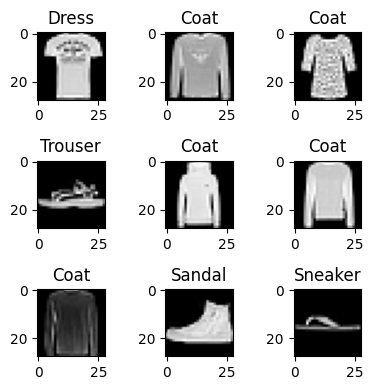

In [84]:
# see how performance the training with mapped_labels 
n_row = 3
n_col = 3

n=n_row * n_col
images=X_train[:n]
images = images.reshape(n,28,28)

labels = cnn_fake_labels
fig, axes=plt.subplots(n_row, n_col, figsize=(4,4))
for i in range(n):
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"{classes_names[labels[i]]}")
plt.tight_layout()
plt.show()

In [85]:
metrics.accuracy_score(y_test, cnn_fake_labels)

0.43666666666666665